# <center>Applied Data Science Capstone Project: Moving from Connecticut to New York </center>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Introduction](#1)<br>
2. [Data acquisition](#2)<br>
    3.1. [Census Data - Processing, Transformation and EVA](#3.1)<br>
    3.2. [Geodata - Processing, Transformation and Plotting](#3.2)<br>
    3.3. [Foursquare](#3.3)<br>
4. [Recommendation System](#4) <br>
5. [Results](#5) <br>
6. [Discussion](#6) <br>
7. [Conclusion](#7) <br>
</div>
<hr>

## Part 1: Introduction<a id="1"></a>

##### In many cases when a person has to move to another city or even country she knows nothing about the new location and it becomes extreamly diffictlt to choose optimal place to search for a new home/flat. The system developed in this project hopes to help to solve this problem by providing clear description of possible locations according to the person's preferences.
##### Possible target audience of such project - real estate agencies, families which move to another region, companies that often need to relocate their employees.  
##### In this project we will develop recomendation system on the examlpe of an young family that decided to move to another city. 
So, meet Jack and Jessy, a young couple from Torrington, Connecticut. Jack has just received an invitation for a job as a new Data Scientist from a high-tech company located in Kings County, New York.  
Jack and Jessy don't want to miss this excellent opportunity, so they decided to move to New York.  
Anxious to find a new wonderful home, Jack and Jessy wrote a list of desirable and unwanted features of their future neighborhood, alongside with budget limitations (they currently rent a house and don't plan to buy it in the nearest future).
Here this list:  
+ In the radius of up to 500m they would be glad to have:  
 * Some restaurant or cafe;
 * Transportation hub (they don't want to buy a car);
 * Some park or lake;
 * Veterinarian or some pet clinic (they have two dogs), also some specialized pet store;
 * Gym, stadium or any other sport facility;
+ Venues that are not desirable:
 * Any kind of night clubs;
 * Tourism infrastructure (it is loud and noisy);
  
Below you can see these preferences with the scale, where -10 is "most undesirable" and +10 is "most wanted":  
  
**Venue type** | **Score**
:--- | ---: 
Restaurant or Cafe | 6
Transportation | 8
Park or lake | 6
Pet Care | 5
Sport facility | 8
Night clubs and pubs | -8
Tourism infrastructure | -7
   
Jeck and Jessy understand that living in New York is not cheap, so they are ready to increase their total living expences up to 20%. (We will need to get their current expences from the dataset bellow)

---

## Part 2: Data acquisition<a id="2"></a>

In this project we will use the data set called **"Median Household Income 2010, Census Tracts"** provided by BetaNYC portal:  
http://data.beta.nyc/dataset/median-household-income-2010-census-tracts

The *csv* file we can download using **!wget**:

In [1]:
!wget -O "data/BetaNYC.csv" --quiet http://data.beta.nyc//dataset/d6ffa9a4-c598-4b18-8caf-14abde6a5755/resource/5a7c26b5-f8b0-4a3f-87fe-56a9c2ff5692/download/ce0a29b4e12a40e491e547a7603b8611csvmedianhouseholdincomecensustract.csv
print('Data loaded successfully!')

Data loaded successfully!


According to the description file located on the BetaNYC portal, the data has the following structure: 

**Column Name** | **Description**
--- | ---
*STATEFP10* | State FIPS Code
*COUNTYFP10* | County FIPS Code
*TRACTCE10* | Census Tract Code
*GEOID10* | ACS identifier
*INTPLAT10* | Latitude
*INTPLTON10* | Longitude
*STATE* | State Name
*COUNTY* | County Name
*HH_COUNT* | Number of Households
*OHU_OWN* | Number of Owned Occupied Housing Units
*OHU_RENT* | Number of Rented Occupied Housing Units
*PERC_OWN* | Percent of OHU owned
*PERC_RENT* | Percent of OHU rented
*MHI* | Median HH Income 
*MED_VAL* | Median Value of Occupied Housing Unit
*HOUSINGCOS* | Weighted Housing Costs 
*MCR_ANNUAL* | Annual Median Contract Rent
*MSMOC_TOT* | Monthly Select Owner Costs w/ or w/o Mortgage	
*TAX_RET* | Number of tax returns
*Avg_TransC* | Average transportation costs by county (HTI) 
*REtaxperow* | Real estate taxes paid per OHU owner in census tract	
*DISP_INC* | Disposable Income: MHI minus TTL, Housing, Transportation, and Energy Costs
*energy_costs* | Annual cost of electricity and gas
*REtax_ACS* | Median Real estate taxes of census tract
*AVG_TTL* | Average Federal, State, & Local Taxes Paid
*LOCALNAME* | Name of NYC neighborhood or name of town/borough outside of NYC
*Area* | Area (ft) of Census Tract

As for geojson file, unfortunately wget is getting stuck when wwe try to download it, so we'll have to do it manually from the site and save it in the "data" catalog as "NYC_census_tract_2010_median_income.geojson".  
<br>
Our second data source - Foursquare, from which we will download the information about venues in each location of interest, more precisely - venue name, type and location.

---

## Part 3.1: Census Data - Processing, Transformation and EVA<a id="3.1"></a>

In [2]:
# Import standart libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set pandas options:
pd.options.display.max_rows=50

Load the saved **csv** file into the dataframe and leave only the relevant data:

In [3]:
# Load data into pandas dataframe and show a few rows:
df_BetaNYC = pd.read_csv('data/BetaNYC.csv', dtype={'GEOID10':'str'})
df_BetaNYC.head()

,FID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,INTPTLAT10,INTPTLON10,State,COUNTY,HH_COUNT,OHU_OWN,OHU_RENT,PERC_OWN,PERC_RENT,MHI,MED_VAL,HOUSINGCOS,MCR_ANNUAL,MSMOC_TOT_,TAX_RET,Avg_TransC,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area
0,0,34,17,32400,34017032400,40.792844,-74.013482,New Jersey,Hudson County,2187,453,1543,0.226954,0.773046,37234,414000,14075.6994,11532,22740,2264.889916,4145.566539,4966.370331,12232.00950,1773.280152,7735,5007.444405,West New York Town,0.000036
1,1,34,17,10100,34017010100,40.691559,-74.110913,New Jersey,Hudson County,2255,867,1353,0.390541,0.609459,53614,424400,17543.1405,10968,27804,2363.430717,5969.286255,4490.984109,22077.84024,1876.844806,7917,6146.888195,Bayonne City,0.000106
2,2,34,17,10200,34017010200,40.682103,-74.104573,New Jersey,Hudson County,1218,622,686,0.475535,0.524465,54020,328300,19156.2936,11076,28068,1260.718928,6014.489564,3339.224580,20488.60531,2167.175106,7692,6193.436421,Bayonne City,0.000031
3,3,34,17,10300,34017010300,40.672439,-74.081016,New Jersey,Hudson County,1093,534,629,0.459157,0.540843,43101,363000,15682.0705,9792,22620,1229.562591,4798.787758,3793.386763,15514.61337,2163.964082,7831,4941.564294,Bayonne City,0.000108
4,4,34,17,10400,34017010400,40.670599,-74.089940,New Jersey,Hudson County,1571,813,785,0.508761,0.491239,68368,365600,15672.0976,10440,20724,2209.874484,7611.970058,4478.110461,35131.00534,2114.480847,7918,7838.446154,Bayonne City,0.000234


In [4]:
# Rename columns:
df_BetaNYC.rename(columns={'GEOID10'     : 'ID',
                           'INTPTLAT10'  : 'Latitude',
                           'INTPTLON10'  : 'Longitude',
                           'STATE'       : 'State',
                           'COUNTY'      : 'County',
                           'MCR_ANNUAL'  : 'Rent',
                           'energy_cos'  : 'Energy',
                           'AVG_TTL'     : 'Taxes',
                           'Avg_TransC'  : 'Transportation',
                           'LOCALNAME'   : 'Neighborhood'},
                  inplace=True)

# Select only columns of interest:
df_BetaNYC = df_BetaNYC[['ID','County','State','Neighborhood','Latitude','Longitude','Rent','Taxes','Energy','Transportation']]

# Add column with total living costs:
df_BetaNYC.loc[:,'Total Costs'] = df_BetaNYC[['Rent','Taxes','Energy','Transportation']].sum(axis=1)

# Print several rows:
df_BetaNYC.head()

,ID,County,State,Neighborhood,Latitude,Longitude,Rent,Taxes,Energy,Transportation,Total Costs
0,34017032400,Hudson County,New Jersey,West New York Town,40.792844,-74.013482,11532,5007.444405,1773.280152,4145.566539,22458.291096
1,34017010100,Hudson County,New Jersey,Bayonne City,40.691559,-74.110913,10968,6146.888195,1876.844806,5969.286255,24961.019256
2,34017010200,Hudson County,New Jersey,Bayonne City,40.682103,-74.104573,11076,6193.436421,2167.175106,6014.489564,25451.101091
3,34017010300,Hudson County,New Jersey,Bayonne City,40.672439,-74.081016,9792,4941.564294,2163.964082,4798.787758,21696.316134
4,34017010400,Hudson County,New Jersey,Bayonne City,40.670599,-74.089940,10440,7838.446154,2114.480847,7611.970058,28004.897059


Show basic information about the dataset:

In [5]:
# Print the shape of the dataframe:
df_BetaNYC.shape

(5296, 11)

In [6]:
# Print the basic statistics in the transposed form (easier to read)
df_BetaNYC.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,5296.0,40.808569,0.331569,39.543776,40.659921,40.750672,40.891729,42.129367
Longitude,5296.0,-73.900305,0.412502,-75.195948,-74.117012,-73.938064,-73.784372,-71.946386
Rent,5296.0,12678.908610,4865.409851,0.000000,10164.000000,12180.000000,15060.000000,24012.000000
Taxes,5296.0,9686.656235,8513.502773,0.000000,4116.955432,7250.248020,12359.364935,69372.213300
Energy,5296.0,2233.863884,621.267927,0.000000,1818.088692,2188.280857,2647.893324,4270.032869
Transportation,5296.0,9982.498224,6572.163996,0.000000,4890.287092,8282.226437,14177.560102,40661.437650
Total Costs,5296.0,34581.926954,17461.063124,0.000000,22484.258552,31070.310254,43701.962327,132838.938005


Excellent, there is no missing data in the dataset, we can proceed further:

In [7]:
# Show how many records are related to each state:
df_BetaNYC.State.value_counts().to_frame().rename(columns={'State':'Number of records'})

,Number of records
New York,3303
New Jersey,1542
Connecticut,451


In [8]:
# Show how many records are related to each county:
df_BetaNYC.County.value_counts().to_frame().rename(columns={'State':'Number of records'})

,County
Kings County,760
Queens County,669
Bronx County,339
Suffolk County,322
New York County,288
Nassau County,279
Westchester County,223
Fairfield County,210
Essex County,210
New Haven County,190


Jack and Jessy know that their current census tract number is **9005310200**, so lets extract the information about this location and save it:

In [9]:
# Select the record with proper ID number:
JJ_current_location = df_BetaNYC.loc[df_BetaNYC.ID == '9005310200']

# Print it:
JJ_current_location

,ID,County,State,Neighborhood,Latitude,Longitude,Rent,Taxes,Energy,Transportation,Total Costs
5088,9005310200,Litchfield County,Connecticut,Torrington,41.809665,-73.129243,7920,4137.877963,1723.07764,7042.546596,20823.502199


Now after we've saved the information about their Torrington census tract, we can leave the information related only to **Kings County**:

In [10]:
# Subselect only records related to Kings County:
df_KC = df_BetaNYC.loc[df_BetaNYC.County == 'Kings County']

# Show basic statistics:
df_KC.describe()

,Latitude,Longitude,Rent,Taxes,Energy,Transportation,Total Costs
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,40.648854,-73.954088,11543.005263,5467.251319,1890.534239,4328.818778,23229.609599
std,0.036257,0.038895,3462.927011,4119.488964,386.276850,1952.023646,8816.018425
min,40.572099,-74.042077,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.620972,-73.982692,10242.000000,2828.969543,1687.650318,3068.164675,18644.610506
50%,40.646374,-73.954396,11448.000000,4345.297720,1870.479902,3914.905443,21572.229835
75%,40.678792,-73.927676,12876.000000,6975.704512,2091.654339,5365.779960,26807.176218
max,40.735120,-73.862798,24012.000000,34859.507570,3322.062053,14675.790500,75692.213569


Lets plot the histogram of Total Costs:

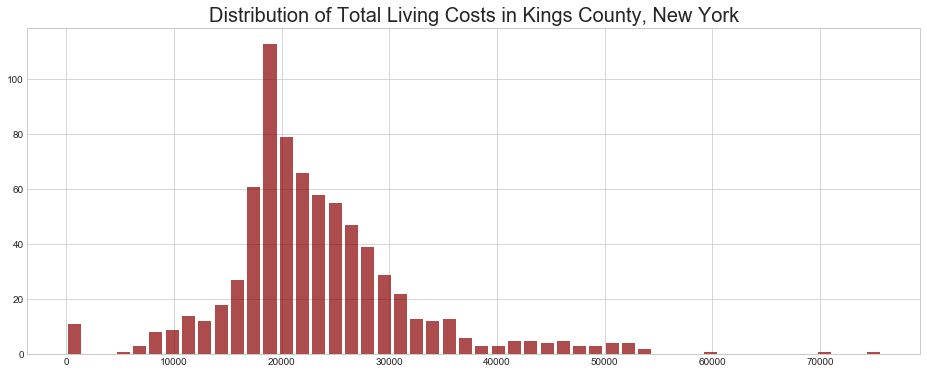

In [11]:
# Plot distribution of Total Costs:

# Set style:
mpl.style.use('seaborn-whitegrid')

# Plot histogram:
fig, ax = plt.subplots(figsize=(16,6))
ax.hist(df_KC['Total Costs'], bins=50, color='darkred', alpha=0.7, rwidth=0.8)
ax.set_title('Distribution of Total Living Costs in Kings County, New York', fontdict={'fontsize':20})

plt.show()

Obviously there is no "free cheese", so records with any cost less or equal to 0 we will consider as invalid. Also we need to filter out records with *Total Costs* higher than 120% of Jessy and Jack current expences:

In [12]:
# Subselect records that mutch the specified criterias:
df_KC_clean = df_KC.loc[(df_KC.iloc[:,-5:] > 0).all(axis=1) & (df_KC['Total Costs']  < float(JJ_current_location['Total Costs']) * 1.20)]
df_KC_clean.reset_index(drop=True, inplace=True)
df_KC_clean.iloc[:,-5:].describe().T

,count,mean,std,min,25%,50%,75%,max
Rent,488.0,10398.098361,2066.371015,2928.000000,9792.000000,10764.000000,11670.000000,15120.000000
Taxes,488.0,3502.092720,1403.172137,679.817961,2441.186064,3288.775504,4434.181496,8896.434935
Energy,488.0,1860.291448,264.803473,1061.652644,1686.658465,1835.560264,2015.396262,3014.917442
Transportation,488.0,3382.934291,982.771823,809.679554,2766.187754,3371.221049,3918.278732,6524.662495
Total Costs,488.0,19143.416820,3705.882887,5679.753384,17571.703265,19381.077119,21596.348366,24950.398493


Lets once again plot the histogram of Total Costs, and below it four graphs of distribution of weight of each component in the Total Costs:

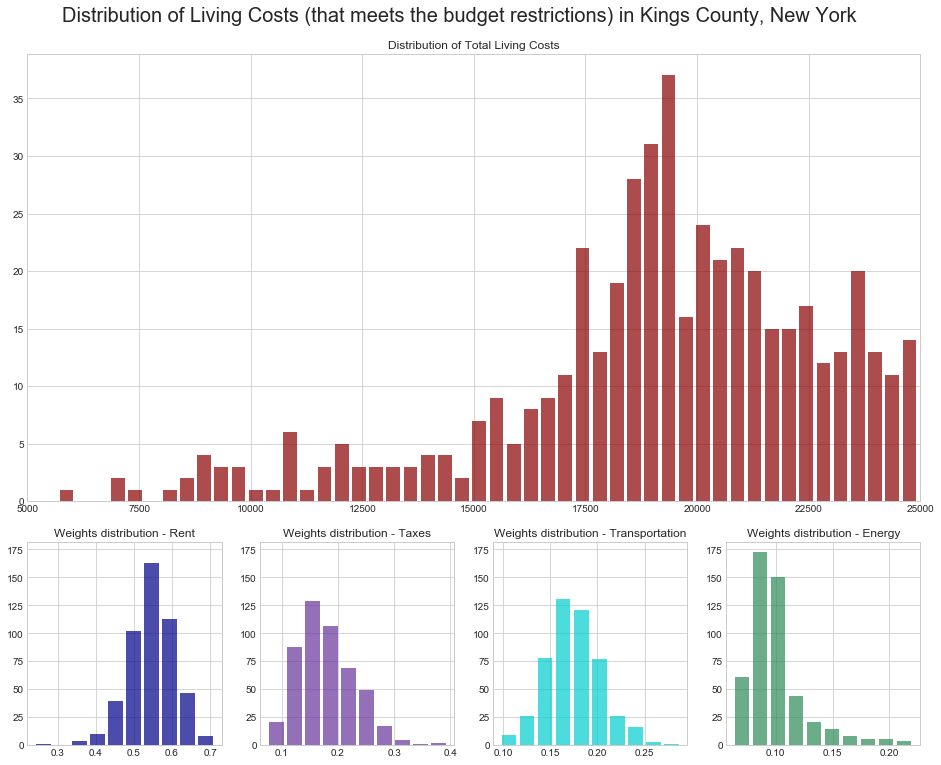

In [13]:
# Set the canvas:
fig = plt.figure(figsize=(16,12))
gs = mpl.gridspec.GridSpec(3,4)

# Add the first graph - histogram of Total Costs:
ax0 = fig.add_subplot(gs[:2,:])
ax0.hist(df_KC_clean['Total Costs'], bins=50, color='darkred', alpha=0.7, rwidth=0.8)
ax0.set_xlim(5000,25000)  # we can find proper values in the table above
ax0.set_title('Distribution of Total Living Costs')

# Add three other subplots with the distribution of each component weight in Total costs:
# Rent:
ax1 = fig.add_subplot(gs[2,0])
ax1.hist(df_KC_clean['Rent'] / df_KC_clean['Total Costs'], bins=10, color='darkblue', alpha=0.7, rwidth=0.8)
ax1.set_title('Weights distribution - Rent')
# Taxes:
ax2 = fig.add_subplot(gs[2,1], sharey=ax1)
ax2.hist(df_KC_clean['Taxes'] / df_KC_clean['Total Costs'], bins=10, color='rebeccapurple', alpha=0.7, rwidth=0.8)
ax2.set_title('Weights distribution - Taxes')
# Transportation:
ax3 = fig.add_subplot(gs[2,2], sharey=ax1)
ax3.hist(df_KC_clean['Transportation'] / df_KC_clean['Total Costs'], bins=10, color='darkturquoise', alpha=0.7, rwidth=0.8)
ax3.set_title('Weights distribution - Transportation')
# Energy:
ax4 = fig.add_subplot(gs[2,3], sharey=ax1)
ax4.hist(df_KC_clean['Energy'] / df_KC_clean['Total Costs'], bins=10, color='seagreen', alpha=0.7, rwidth=0.8)
ax4.set_title('Weights distribution - Energy')

# Set supertitle:
fig.suptitle('Distribution of Living Costs (that meets the budget restrictions) in Kings County, New York', size=20)
fig.subplots_adjust(top=0.925)

# Show the graphs:
plt.show()

As we can see, most of the regions (census tracts) have annual living expenses above $15,000.  
In most cases Rent expenses accont for more than 50% of this cost; Energy costs rearly exceed 10%.

## Part 3.2: Geodata - Processing, Transformation and Plotting<a id="3.2"></a>

##### Load geodata from geojson file that we've saved earlier:

In [14]:
import json

with open('data/NYC_census_tract_2010_median_income.geojson') as geofile:
    geodata = json.load(geofile)

print('There are {} entities in the geodata file'.format(len(geodata['features'])))

There are 5296 entities in the geodata file


Now we need to subset only relevant records:

In [15]:
# Create dict to store relevant records:
sub_geodata = {"type":"FeatureCollection", "features":[]}

# Save 'ID' values that are present in our dataset:
sub_id = df_KC_clean['ID'].values

# Iterate over records in the geofile:
for i in range(len(geodata['features'])):
    sub_dict = geodata['features'][i]
    
    # Check if the record has 'ID' that exist in the dataframe:
    if sub_dict['properties']['GEOID10'] in sub_id:
        
        # Save the data in the dict that we've created earlier:
        sub_geodata['features'].append({'type':'Feature',
                                        'properties':{'ID':sub_dict['properties']['GEOID10']},
                                        'geometry':sub_dict['geometry']
                                        })

print('There were {} records with geoshape data'.format(len(sub_geodata['features'])))

There were 488 records with geoshape data


There was information about every census tract in our dataframe, excelent! Now we can plot the map:

In [16]:
from geopy.geocoders import Nominatim

# Get coordinates to center the map:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('Kings County, New York City, NY')
lat = location.latitude
lng = location.longitude
print('Kings County coordinates is: {:.4f} latitude and {:.4f} longitude'.format(lat, lng))

Kings County coordinates is: 40.6453 latitude and -73.9550 longitude


In [17]:
# Import libraries:
import folium
from folium.plugins import ScrollZoomToggler
from folium import Choropleth

'''
Possible color maps:
'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn',
'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr','YlOrRd'
'''

# Create map object:
KC_map = folium.Map(location=[lat, lng+0.05], zoom_start=12, tiles='Stamen Toner')  # Shift the map a little bit to make the legent visible

# Add controls to the Map (to disable default zoom by scrolling):
KC_map.add_child(ScrollZoomToggler())

# Add color layer:
Choropleth(
    geo_data=sub_geodata,
    data=df_KC_clean,
    columns=['ID', 'Total Costs'],
    key_on='feature.properties.ID',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    threshold_scale=np.linspace(5000, 25000, 5, dtype=int),
    legend_name='Median Annual Total Cost of Living'
).add_to(KC_map)

KC_map

## Part 3.3: Foursquare<a id="3.3"></a>

We will get information about the venues in each region from Foursqare in two steps:  
1. Download request results from Foursquare;
2. Process the result and extract the relevant information.  
  
In that way we would be able to extract additional information in the future without additional request to Foursquare.  
Before we begin, lets append Jack and Jessy's data to the main dataframe in order to apply the same transformation on both datasets, later we will extract it again:


In [18]:
# Append the JJ record:
df_all_clean = df_KC_clean.append(JJ_current_location, ignore_index=True, sort=False)

# Show last few records to check that everything is OK:
df_all_clean.tail()

,ID,County,State,Neighborhood,Latitude,Longitude,Rent,Taxes,Energy,Transportation,Total Costs
484,36047068000,Kings County,New York,Old Mill Basin,40.621376,-73.925188,7716,5958.192311,2259.722906,4808.062680,20741.977897
485,36047072800,Kings County,New York,Flatlands,40.629486,-73.927004,11988,5739.818153,1983.564511,4631.842010,24343.224674
486,36047073600,Kings County,New York,Flatbush-East,40.624039,-73.935795,11388,4801.449630,1808.062618,3707.380642,21704.892890
487,36047074000,Kings County,New York,Flatbush-East,40.627394,-73.941257,9312,7269.198102,1977.559836,5156.276162,23715.034100
488,9005310200,Litchfield County,Connecticut,Torrington,41.809665,-73.129243,7920,4137.877963,1723.077640,7042.546596,20823.502199


Now we can fetch the data from Foursquare.  
Stage 1: Get the data from Foursquare:

In [20]:
import json
import requests


# Create dict to store venues info:
foursquare_data = {}

# Set credentials:
CLIENT_ID = 'IBTKUPYZLKIZKZZCQP0FKFVVQ2JVFO30ZWJ0TD5LJHKWT5IN'
CLIENT_SECRET = 'H251ZYFKWLVT0C0QTMAOUTEFU2NCMXEV4S322HM1XTP2DSNI'
VERSION = '20190605'

# Iterate over dataframe rows and get venues info from Foursquare:
for ind, row in df_all_clean.iterrows():
    lat = row.Latitude
    lng = row.Longitude
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    lat,
    lng,
    500,
    200)

    # Get venues and save it into the dict:
    foursquare_data[row.ID] = requests.get(url).json()

Dump the result into pickle file:

In [19]:
# Import libraries:
import pickle

# To dump the data change 'False' to 'True'
if False:
    with open('data/foursquare_data.pkl','wb') as f:
        pickle.dump(foursquare_data, f)
else:
    with open('data/foursquare_data.pkl','rb') as f:
        foursquare_data = pickle.load(f)

Stage 2: Process the result and extract required information:

In [21]:
# Create empty data frame to store results:
df_all_venues = pd.DataFrame(columns=['ID','Venue','Latitude','Longitude','Subcategory'])

# Iterate over postal codes and store venue info for each in the data frame:
for ID, data in foursquare_data.items():
    # Pass if there is no venues for this Postal code:
    if data['response']['totalResults'] == 0:
        print('There is no venues for', ID)
    else:
        venues = data['response']['groups'][0]['items']
    
    # Convert results into pandas data frame:
    temp_df = pd.DataFrame([{'ID'          : ID,
                             'Venue'       : v['venue']['name'],
                             'Latitude'    : v['venue']['location']['lat'],
                             'Longitude'   : v['venue']['location']['lng'],
                             'Subcategory' : v['venue']['categories'][0]['name']} for v in venues])
    
    # Append results to venues_df:
    df_all_venues = df_all_venues.append(temp_df, sort=False, ignore_index=True)
    
# Print few rows from venues dataframe:
df_all_venues.head(3)

,ID,Venue,Latitude,Longitude,Subcategory
0,36047031500,Café Cotton Bean,40.676133,-73.950327,Coffee Shop
1,36047031500,King Tai,40.676088,-73.949688,Cocktail Bar
2,36047031500,India House,40.678708,-73.949651,Indian Restaurant


Lets plot the distribution of the number of venues per census tracts and by subcategory:

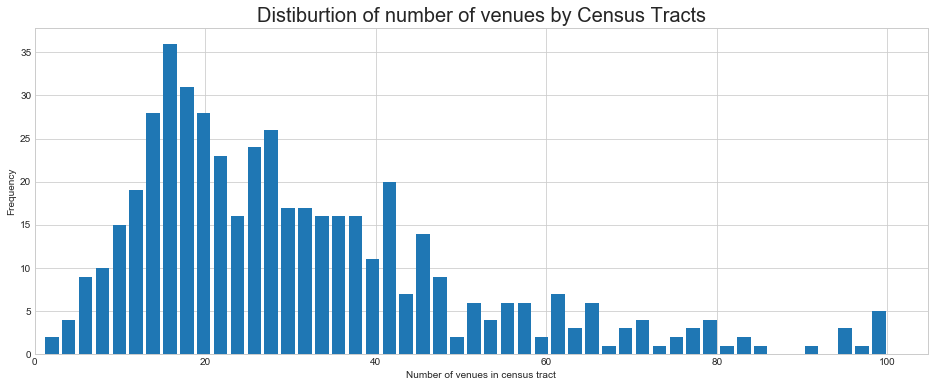

In [22]:
# Show the venues distribution by Census Tracts:
plt.figure(figsize=(16,6))
df_all_venues.groupby('ID').Venue.count().plot(kind='hist', bins=50, rwidth=0.8)
plt.title('Distiburtion of number of venues by Census Tracts', fontdict={'fontsize':20})
plt.xlabel('Number of venues in census tract')
plt.xlim(0)
plt.show()

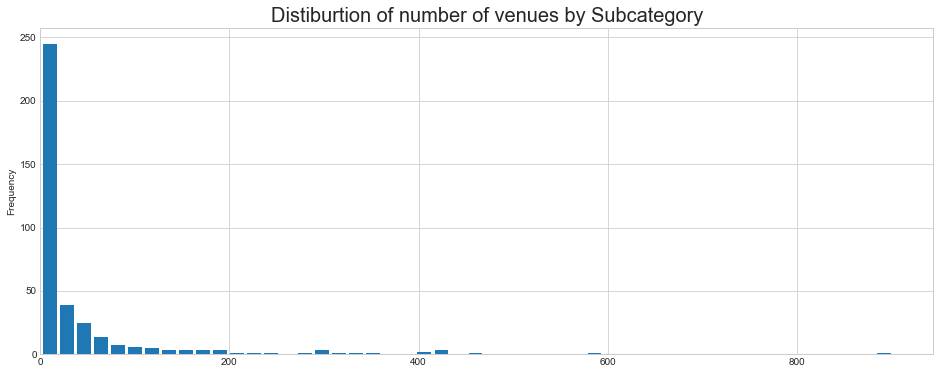

In [23]:
# Show venues number distribution by Subcategory:
plt.figure(figsize=(16,6))
df_all_venues['Subcategory'].value_counts().plot(kind='hist', bins=50, rwidth=0.8)
plt.title('Distiburtion of number of venues by Subcategory', fontdict={'fontsize':20})
plt.xlim(0)
plt.show()

Most of the subcategories appears in the dataset only several times, so we need to group them into more general categories. I've created excel file with the subcategory-category match:

In [24]:
# Read data from excel file:
venue_categories = pd.read_excel('data/venue_categories.xlsx')
venue_categories.head()

,Subcategory,Category
0,Gym,"Health, Sport and Beauty"
1,Gym / Fitness Center,"Health, Sport and Beauty"
2,Boxing Gym,"Health, Sport and Beauty"
3,Gym Pool,"Health, Sport and Beauty"
4,Stadium,"Health, Sport and Beauty"


In [25]:
# Merge the dataset with category labels:
df_all_venues = pd.merge(left=df_all_venues,
                         right=venue_categories,
                         on='Subcategory',
                         how='left')
df_all_venues.head()

,ID,Venue,Latitude,Longitude,Subcategory,Category
0,36047031500,Café Cotton Bean,40.676133,-73.950327,Coffee Shop,Food
1,36047031500,King Tai,40.676088,-73.949688,Cocktail Bar,Bars and Clubs
2,36047031500,India House,40.678708,-73.949651,Indian Restaurant,Café & Restaurant
3,36047031500,Furman's,40.678783,-73.949617,Coffee Shop,Food
4,36047031500,Nostrand Avenue Pub,40.675905,-73.949993,Pub,Bars and Clubs


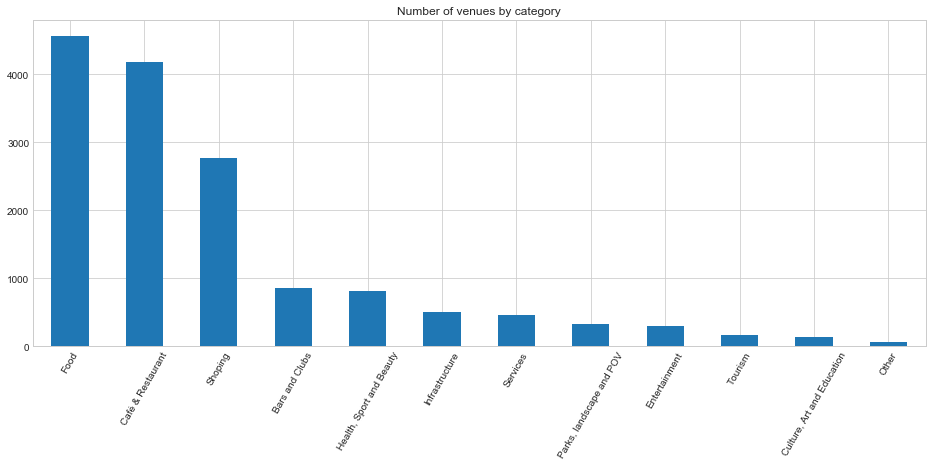

In [26]:
# Show venues number distribution by Category:
plt.figure(figsize=(16,6))
df_all_venues.Category.value_counts().plot(kind='bar')
plt.title('Number of venues by category')
plt.xticks(rotation=60)
plt.show()

Lets remind what was Jack's and Jessy's preferences:
  
**Venue type** | **Score**
:--- | ---: 
Restaurant or Cafe | 6
Transportation | 8
Park or lake | 6
Pet Care | 5
Sport facility | 8
Night clubs and pubs | -8
Tourism infrastructure | -7

##### There are 6 Categories and 1 Subcategory in this list, so before we proceed we need to add one additional Category called "Pets Care" that would include subcategory with words "pet" and "veterinarian":

In [27]:
# Assign Category = "Pets Care" to records which Subcategory label contains the keywords:
df_all_venues.loc[df_all_venues.Subcategory.str.contains('pet|veterinarian', regex=True, case=False), 'Category'] = 'Pet Care'

# Check the result:
df_all_venues.query('Category == "Pet Care"')['Subcategory'].value_counts()

Pet Store       49
Pet Service      4
Veterinarian     2
Name: Subcategory, dtype: int64

Excellent, now we can move on to recomendations!

---

## Part 4: Recommendation System<a id="4"></a>

Our first step would be creation of the dataframe that would include specified by Jack and Jessy categories alongside with their scores:

In [28]:
# Create the dataframe from dict:
df_scores = pd.DataFrame.from_dict({'Café & Restaurant'        : 6,
                                    'Infrastructure'           : 8,
                                    'Parks, landscape and POV' : 6,
                                    'Pet Care'                 : 5,
                                    'Health, Sport and Beauty' : 8,
                                    'Bars and Clubs'           :-8,
                                    'Tourism'                  :-7},
                                   orient='index',
                                   columns=['Score'])

# Show the dataframe:
df_scores

,Score
Café & Restaurant,6
Infrastructure,8
"Parks, landscape and POV",6
Pet Care,5
"Health, Sport and Beauty",8
Bars and Clubs,-8
Tourism,-7


Next step - leave only records with relevant categories:

In [29]:
df_candidates = df_all_venues.loc[df_all_venues.Category.isin(df_scores.index.tolist())]
df_candidates.head()

,ID,Venue,Latitude,Longitude,Subcategory,Category
1,36047031500,King Tai,40.676088,-73.949688,Cocktail Bar,Bars and Clubs
2,36047031500,India House,40.678708,-73.949651,Indian Restaurant,Café & Restaurant
4,36047031500,Nostrand Avenue Pub,40.675905,-73.949993,Pub,Bars and Clubs
5,36047031500,Uotora,40.676151,-73.950473,Sushi Restaurant,Café & Restaurant
6,36047031500,The Sanctuary Juice Bar,40.675504,-73.950111,Juice Bar,Café & Restaurant


Now we need to count number of venues of each category by region ID:

In [30]:
df_candidates = df_candidates.groupby(['ID','Category'], as_index=False).Subcategory.count()
df_candidates.head()

,ID,Category,Subcategory
0,36047000200,Bars and Clubs,3
1,36047000200,Café & Restaurant,14
2,36047000200,"Health, Sport and Beauty",1
3,36047000200,Pet Care,1
4,36047000200,Tourism,1


We need to transform the dataframe into right form: Category labels as columns and region IDs as index. Istead of one-hot encoging (where we get 0/1 values), we will use pivot table method (because in our case it's reasonable to preserve the number of venues of each category):

In [31]:
# Pivot the dataframe:
df_candidates = pd.pivot_table(data=df_candidates, index='ID', columns='Category', fill_value=0)

# Reset the column multiindex:
df_candidates.columns = df_candidates.columns.droplevel(0)

# Reorder columns according to the index of df_scores:
df_candidates = df_candidates[df_scores.index.tolist()]

# Print a few rows to check the result:
df_candidates.head()

Category,Café & Restaurant,Infrastructure,"Parks, landscape and POV",Pet Care,"Health, Sport and Beauty",Bars and Clubs,Tourism
ID,,,,,,,
36047000200,14,0,0,1,1,3,1
36047002000,4,2,0,0,2,3,0
36047002200,3,1,1,0,0,1,0
36047002300,12,1,8,0,9,6,1
36047002901,4,2,4,0,8,2,0


Now when we have all the data cleaned and prepared, we can finally calculate weighted score of each region (Census Tract)!

In [32]:
# Multiply two dataframes (matrix multiplication) and sort the result:
df_recommendations = df_candidates.dot(df_scores).sort_values(by='Score',ascending=False)

# Show first 20 rows:
df_recommendations.head(20)

,Score
ID,
36047010600,214
36047079801,199
36047029000,180
36047032700,171
36047079601,163
36047010400,162
36047050803,162
36047055400,159
36047006800,159


Now when we have the scores for each region, it would be interesting to check what venues are located in this regions and what is their median annual cost of living:

In [51]:
# Concatenate scores, venue counts and total cost of living into a single dataframe:
df_results = pd.concat([df_recommendations,
                        df_candidates,
                        df_all_clean.set_index('ID').loc[df_recommendations.index, 'Total Costs']],
                        axis=1,
                        sort=False)

# Show 5 best and 5 worst regions:
df_results.head().append(df_results.tail())

,Score,Café & Restaurant,Infrastructure,"Parks, landscape and POV",Pet Care,"Health, Sport and Beauty",Bars and Clubs,Tourism,Total Costs
36047010600,214,33,0,0,0,3,1,0,18123.882368
36047079801,199,26,1,1,1,7,4,0,18803.643250
36047029000,180,26,1,0,0,2,0,0,20452.762195
36047032700,171,23,1,2,1,5,4,0,17782.949692
36047079601,163,28,0,1,1,3,5,0,19334.647301
36047123700,-6,2,3,2,0,0,5,2,23768.295222
36047053100,-7,0,0,0,0,0,0,1,21838.451249
36047083600,-9,0,0,1,0,1,2,1,23724.142655
36047040900,-28,1,0,1,0,2,7,0,19337.181729
36047039300,-31,12,0,0,0,1,13,1,20354.618980


We need only records with the possitive scores, where undesirable venues are at least compensated by the attracitve ones:

In [52]:
df_results = df_results.query('Score >= 0')

# Show last records:
df_results.tail()

,Score,Café & Restaurant,Infrastructure,"Parks, landscape and POV",Pet Care,"Health, Sport and Beauty",Bars and Clubs,Tourism,Total Costs
36047023200,6,1,0,0,0,0,0,0,17450.534047
36047050500,5,18,0,0,0,5,17,1,15074.617522
36047041700,4,2,0,0,0,0,1,0,14056.718567
36047053300,4,2,1,0,0,0,2,0,16999.941552
36047118201,0,0,1,0,0,0,1,0,24511.745770


---

## Part 5: Results<a id="5"></a>

In the previous section we got a dataframe with census tracts in Kings County that satisfy budget restrictions, rated according to Jack's and Jessy's preferences.

Before we make our counlusions, lets plot the results as Choropleth map, but before we do it let us normalize the Score values to make it more clear. We will use the scale from 0 to 100, where score 0 would mean that this region is not attractive at all to  Jack and Jessy, and score of 100 - the most desirable one.

In [53]:
# Apply normalization to 'Score' column, multiply by 100 and convert to integers:
df_results.loc[:, 'Score'] = ((df_results.Score - df_results.Score.min()) / (df_results.Score.max() - df_results.Score.min()) * 100).astype('int')

# Show 5 best and 5 worst regions:
df_results.head().append(df_results.tail())

,Score,Café & Restaurant,Infrastructure,"Parks, landscape and POV",Pet Care,"Health, Sport and Beauty",Bars and Clubs,Tourism,Total Costs
36047010600,100,33,0,0,0,3,1,0,18123.882368
36047079801,92,26,1,1,1,7,4,0,18803.643250
36047029000,84,26,1,0,0,2,0,0,20452.762195
36047032700,79,23,1,2,1,5,4,0,17782.949692
36047079601,76,28,0,1,1,3,5,0,19334.647301
36047023200,2,1,0,0,0,0,0,0,17450.534047
36047050500,2,18,0,0,0,5,17,1,15074.617522
36047041700,1,2,0,0,0,0,1,0,14056.718567
36047053300,1,2,1,0,0,0,2,0,16999.941552
36047118201,0,0,1,0,0,0,1,0,24511.745770


Now we can plot the map:

In [106]:
# Import libraries:
import folium
from folium.plugins import ScrollZoomToggler
from folium import Choropleth

# Create map object:
recommendation_map = folium.Map(location=[lat, lng+0.05], zoom_start=12, tiles='Stamen Toner')  # Use lat and lng that we've received earlier

# Add controls to the Map (to disable default zoom by scrolling):
recommendation_map.add_child(ScrollZoomToggler())

# Add color layer:
Choropleth(
    geo_data=sub_geodata,
    data=df_results.reset_index().rename(columns={'index':'ID'}),
    columns=['ID', 'Score'],
    key_on='feature.properties.ID',
    fill_color='YlGn', 
    fill_opacity=0.9,
    legend_name='Census Tracts attractiveness'
).add_to(recommendation_map)

# Mark 20 most attractive locations:
for i, row in pd.merge(df_results.iloc[:20,[0,-1]].reset_index().rename(columns={'index':'ID'}),
                       df_all_clean[['ID','Latitude','Longitude']],
                       how='left', on='ID').iterrows():
    # Add marker:
    folium.CircleMarker(location=[float(row.Latitude), float(row.Longitude)],
                        popup=folium.Popup('Rating: {}\nCosts: ${:,}'.format(int(row.Score),int(row['Total Costs'])), parse_html=True),
                        color='black',
                        radius=4,
                        weight=1,
                        fill=True,
                        fill_color='cyan',
                        fill_opacity=0.7,
                        parse_html=False).add_to(recommendation_map)
    
# Show the map:
recommendation_map

Second, lets plot the scatterplot 'Rating'-'Median annual Cost of living':

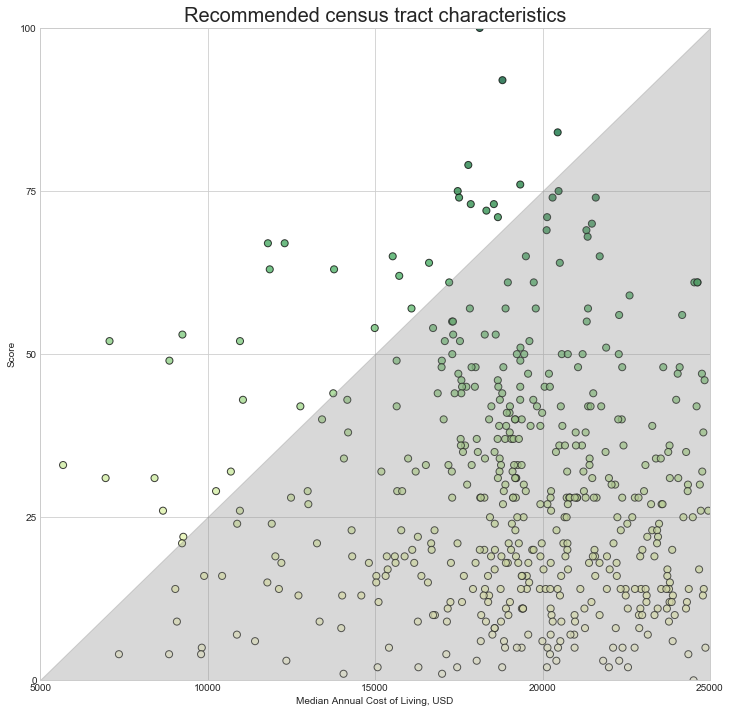

In [152]:
# Create the plot:
fig, ax = plt.subplots(figsize=(12,12))

# Add scatterplot:
ax.scatter(df_results['Total Costs'],
           df_results['Score'],
           c=np.log(df_results['Total Costs']) * df_results['Score'],
           cmap='YlGn',
           edgecolors='black',
           s=50, 
           alpha=0.75)

# Set axis parameters:
ax.set(xlim=(5000,25000),
       ylim=(0,100),
       xticks=range(5000,25001,5000),
       yticks=range(0,101,25),
       xlabel='Median Annual Cost of Living, USD',
       ylabel='Score')

# Add polygon to mark possibly less attractive options:
ax.add_collection(mpl.collections.PatchCollection([
    mpl.patches.Polygon([[5000,0],
                         [25000,0],
                         [25000,100]],closed=True)],
    color='gray',
    alpha=0.3))

# Set title:
ax.set_title('Recommended census tract characteristics', fontsize=20)

# Show the graph:
plt.show()

In the graph above points that located inside the shadded polygon possibly are less attracitve.  
Why? Because for each of these options exists another one that provides higher score or/and lower annual cost.  
Why 'possibly'? Because this is only score representation of computed 'attractiveness' of each recommended location, in the real life it could be the situation that a location with a lower score would be much more interesting for Jack and Jessy.

##### So, now we can give to Jack and Jessy our recommendations what locations they should consider first, alongside with explanations of all the caveats that we've mentioned.

---

## Part 6: Discussion<a id="6"></a>

---

## Part 7: Conclusion<a id="7"></a>